# SWAN BOUNDSPEC SEGMENT

This notebooks shows examples of how to prescribe BOUNDSPEC SEGMENT spectral boundaries
using rompy boundary data objects.

Boundary of type `BOUNDSPEC SEGMENT` can be specified from existing spectral data using
the `rompy.swan.boundary.BoundspecSegmentXY` object. The boundary locations can be
defined in three different ways:

| Type | Description |
| --- | --- |
| SIDE | Define boundary segment along one side of computational grid |
| SIDES | Define boundary segment along multiple, contiguous sides of computational grid |
| XY | Define boundary segment from a sequency of points explicitly provided |


The boundary spectra are defined by interpolating or nearest-selecting from the source
spectra data at the selected boundary locations.

This class only supports `FILE` type boundary since the `PAR` type does not allow for
nonstationary boundary specification (the user can prescribe `PAR` type boundary by
using the SWAN components if required).

We currently support `TPAR` and `SPEC2D` file types to write the boundary data.


In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
from tempfile import mkdtemp
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
import cartopy.crs as ccrs
import pandas as pd
import wavespectra

from rompy.core.data import SourceFile
from rompy.core.time import TimeRange
from rompy.swan.grid import SwanGrid
from rompy.swan.boundary import BoundspecSegmentXY
from rompy.swan.subcomponents.boundary import SIDE, SIDES, XY

import warnings
warnings.filterwarnings('ignore')

## Helper functions

In [2]:
def read_tpar(tparfile):
    """Read SWAN TPAR files as a Dataframe."""
    df = pd.read_csv(
        tparfile,
        sep=" ",
        header=None,
        skiprows=1,
        parse_dates=[0],
        date_format="%Y%m%d.%H%M%S",
        index_col=0,
    )
    df.columns = ["hs", "tp", "dpm", "dspr"]
    return df


def get_color(cmap, value, vmin, vmax):
    """Return the HEX color for a value in a colormap."""
    cmap = matplotlib.cm.get_cmap(cmap)
    norm = colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    return colors.rgb2hex(cmap(norm(value)))


def plot_boundary_side(dset, tpars, grid, time):
    """Plot side boundary stats.

    This function plots a snapshot of wave statistics from the source spectra dataset
    and the boundary wave stats generated for a grid from those spectra points.

    Parameters
    ----------
    dset: xr.Dataset
        Source spectra dataset used to define the boundary.
    tpars: list[pd.DataFrame]
        Boundary time series defined from TPAR or SWAN ASCII file for each segment.
    grid: SwanGrid
        Grid object defining the SWAN domain.
    time: Datatime | str
        Time to plot.

    """
    # xb, yb = bnd._boundary_points(grid)
    xb = grid.x[:, 0]
    yb = grid.y[:, 0]

    fig, axs = plt.subplots(1, 3, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(15, 3.5))

    # Hs
    ax = axs[0]
    p = ax.scatter(dset.lon, dset.lat, s=65, c=dset.sel(time=time).spec.hs(), cmap="turbo", vmin=2.0, vmax=3.5)
    plt.colorbar(p, label="Hs (m)")
    for df in tpars:
        xb = [df.loc[time]["x0"], df.loc[time]["x1"]]
        yb = [df.loc[time]["y0"], df.loc[time]["y1"]]
        color = get_color("turbo", df.loc[time]["hs"], 2.0, 3.5)
        ax.plot(xb, yb, color=color, linewidth=4, zorder=10)

    # Tp
    ax = axs[1]
    p = ax.scatter(dset.lon, dset.lat, s=65, c=dset.sel(time=time).spec.tp(), cmap="viridis", vmin=13.8, vmax=14.5)
    plt.colorbar(p, label="Tp (s)")
    for df in tpars:
        xb = [df.loc[time]["x0"], df.loc[time]["x1"]]
        yb = [df.loc[time]["y0"], df.loc[time]["y1"]]
        color = get_color("viridis", df.loc[time]["tp"], 13.8, 14.5)
        ax.plot(xb, yb, color=color, linewidth=4, zorder=10)

    # Dpm
    ax = axs[2]
    p = ax.scatter(dset.lon, dset.lat, s=65, c=dset.sel(time=time).spec.dpm(), cmap="hsv", vmin=220, vmax=225)
    plt.colorbar(p, label="Dpm (deg)")
    for df in tpars:
        xb = [df.loc[time]["x0"], df.loc[time]["x1"]]
        yb = [df.loc[time]["y0"], df.loc[time]["y1"]]
        color = get_color("hsv", df.loc[time]["dpm"], 220, 225)
        ax.plot(xb, yb, color=color, linewidth=4, zorder=10)
    # ax.scatter(xb, yb, s=200, c=df.loc[time]["dpm"], marker=">", edgecolor="k", cmap="hsv", vmin=220, vmax=225)

    for ax in axs:
        grid.plot(ax=ax, fscale=5)
        ax.set_extent([110.5, 115.5, -29.5, -23.5])
        ax.set_title(time)
        ax.coastlines()

In [3]:
datadir = Path("../../../tests/data")
modeldir = Path("model")
modeldir.mkdir(exist_ok=True)

### Define rompy objects

Create instances of source, time and grid objects to use with the boundary classes

In [4]:
# source defines the dataset to be used to create the model boundary

source = SourceFile(
    uri=datadir / "aus-20230101.nc",
    kwargs=dict(engine="netcdf4"),
)
dset = source.open()
dset

<xarray.Dataset>
Dimensions:  (time: 5, site: 412, freq: 11, dir: 8)
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01 2023-01-01T06:00:00 ... 2023-01-02
  * site     (site) int64 0 4 8 12 16 20 24 ... 1624 1628 1632 1636 1640 1644
  * freq     (freq) float32 0.05417 0.05959 0.06555 ... 0.1161 0.1277 0.1405
  * dir      (dir) float32 0.0 45.0 90.0 135.0 180.0 225.0 270.0 315.0
Data variables:
    lon      (site) float32 ...
    lat      (site) float32 ...
    efth     (time, site, freq, dir) float64 ...
    dpt      (time, site) float32 ...
    wspd     (time, site) float32 ...
    wdir     (time, site) float32 ...
Attributes: (12/16)
    product_name:           ww3.all_spec.nc
    area:                   Global 0.5 x 0.5 degree
    data_type:              OCO spectra 2D
    format_version:         1.1
    southernmost_latitude:  n/a
    northernmost_latitude:  n/a
    ...                     ...
    minimum_altitude:       n/a
    maximum_altitude:       n/a
    altitude_resolution:    n/a
    start_date:             2023-01-01 00:00:00
    stop_date:              2023-02-01 00:00:00
    field_type:             3-hourly

In [5]:
# times prescribe the times over which the model will run

times = TimeRange(start="2023-01-01T00", end="2023-01-02T00", interval="6h")
times

TimeRange(start=datetime.datetime(2023, 1, 1, 0, 0), end=datetime.datetime(2023, 1, 2, 0, 0), duration=datetime.timedelta(days=1), interval=datetime.timedelta(seconds=21600), include_end=True)

In [6]:
# grid defines the model grid

grid = SwanGrid(x0=112, y0=-29, dx=0.5, dy=0.5, nx=8, ny=9, rot=20)
grid

SwanGrid: REG, 8x9

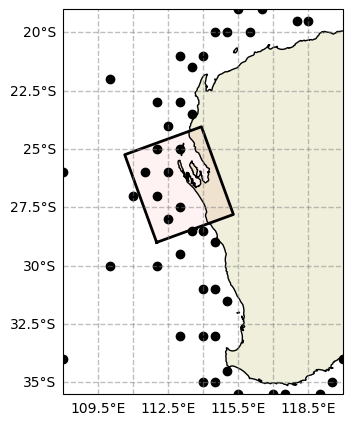

In [7]:
# Plot model grid and boundary points in the source spectra

fig, ax = grid.plot(fscale=5)
ax.plot(dset.lon, dset.lat, "ok")
ax.set_extent([108, 120, -35.5, -19])

### Boundary segment along one side

Create `BOUNDSPEC SEGMENT` type SWAN boundary with the points defined along one side
of the computational grid.

The boundary is defined as `TPAR` files by interpolating from the source spectra
dataset along the grid side. The *Inverse Distance Weighting* (`idw`) sel method from
wavespectra will be used to interpolate from the source spectra at each boundary point.

In [8]:
workspace = Path(mkdtemp(dir="model"))

bnd = BoundspecSegmentXY(
    id="wa",
    source=source,
    sel_method="idw",
    sel_method_kwargs={"tolerance": 2.0},
    location=SIDE(side="west", direction="ccw"),
)

cmd = bnd.get(destdir=workspace, grid=grid, time=times)
filename = cmd.split()[-2].split("=")[-1][1:-1]

print(f"{cmd}\n")
os.system(f"ls -l {workspace}");

BOUNDSPEC SEGMENT XY x=110.63191943 y=-25.24122952 x=110.80292950 y=-25.71107583 CONSTANT FILE fname='wa_tpar_000.bnd' seq=1
BOUNDSPEC SEGMENT XY x=110.80292950 y=-25.71107583 x=110.97393957 y=-26.18092214 CONSTANT FILE fname='wa_tpar_001.bnd' seq=1
BOUNDSPEC SEGMENT XY x=110.97393957 y=-26.18092214 x=111.14494964 y=-26.65076845 CONSTANT FILE fname='wa_tpar_002.bnd' seq=1
BOUNDSPEC SEGMENT XY x=111.14494964 y=-26.65076845 x=111.31595971 y=-27.12061476 CONSTANT FILE fname='wa_tpar_003.bnd' seq=1
BOUNDSPEC SEGMENT XY x=111.31595971 y=-27.12061476 x=111.48696979 y=-27.59046107 CONSTANT FILE fname='wa_tpar_004.bnd' seq=1
BOUNDSPEC SEGMENT XY x=111.48696979 y=-27.59046107 x=111.65797986 y=-28.06030738 CONSTANT FILE fname='wa_tpar_005.bnd' seq=1
BOUNDSPEC SEGMENT XY x=111.65797986 y=-28.06030738 x=111.82898993 y=-28.53015369 CONSTANT FILE fname='wa_tpar_006.bnd' seq=1
BOUNDSPEC SEGMENT XY x=111.82898993 y=-28.53015369 x=112.00000000 y=-29.00000000 CONSTANT FILE fname='wa_tpar_007.bnd' seq=1


In [9]:
# Load boundaries for each segment into dataframes

tpars = []
for row in cmd.split("\n"):
    parts = row.split()
    filename = parts[-2].split("=")[-1][1:-1]
    df = read_tpar(workspace / filename)
    df["x0"] = float(parts[3].split("=")[-1])
    df["x1"] = float(parts[5].split("=")[-1])
    df["y0"] = float(parts[4].split("=")[-1])
    df["y1"] = float(parts[6].split("=")[-1])
    tpars.append(df)

with pd.option_context("display.max_columns", 999):
    display(df)

,hs,tp,dpm,dspr,x0,x1,y0,y1
0,,,,,,,,
2023-01-01 00:00:00,2.91,14.14,224.35,25.31,111.82899,112.0,-28.530154,-29.0
2023-01-01 06:00:00,2.99,14.11,224.08,26.31,111.82899,112.0,-28.530154,-29.0
2023-01-01 12:00:00,3.35,14.25,223.91,28.19,111.82899,112.0,-28.530154,-29.0
2023-01-01 18:00:00,3.62,14.31,224.13,29.76,111.82899,112.0,-28.530154,-29.0
2023-01-02 00:00:00,3.59,14.18,224.47,30.52,111.82899,112.0,-28.530154,-29.0


Plot boundary stats, note the values weighted by the four nearest neighbours at each site along the `WEST` boundary

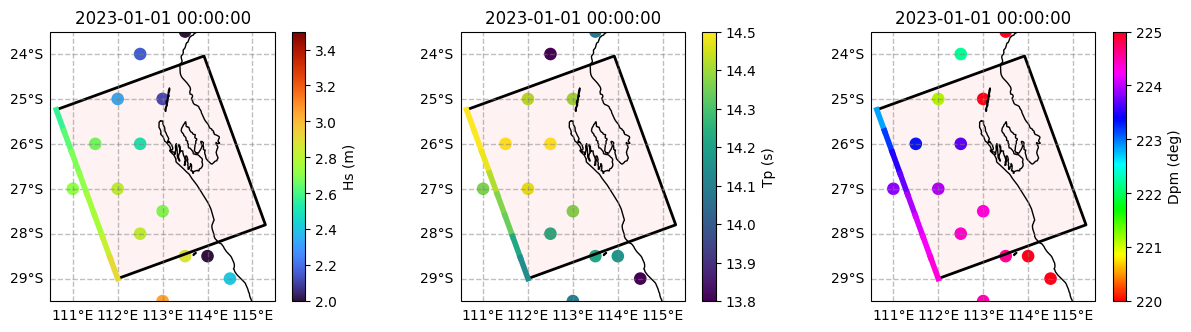

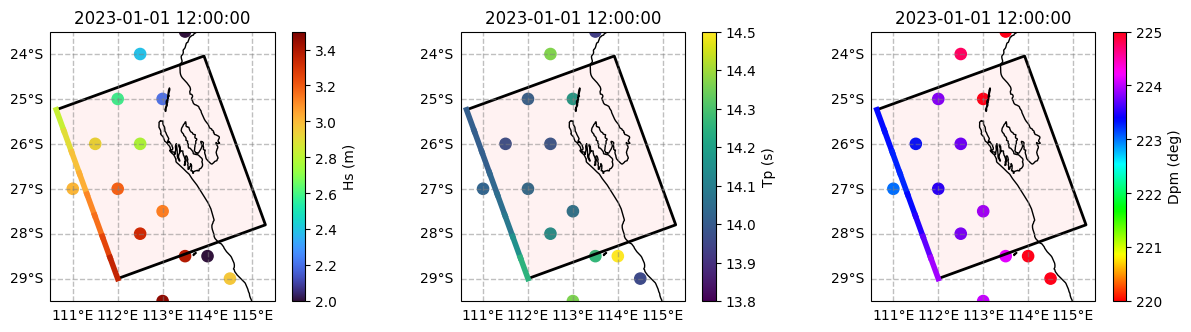

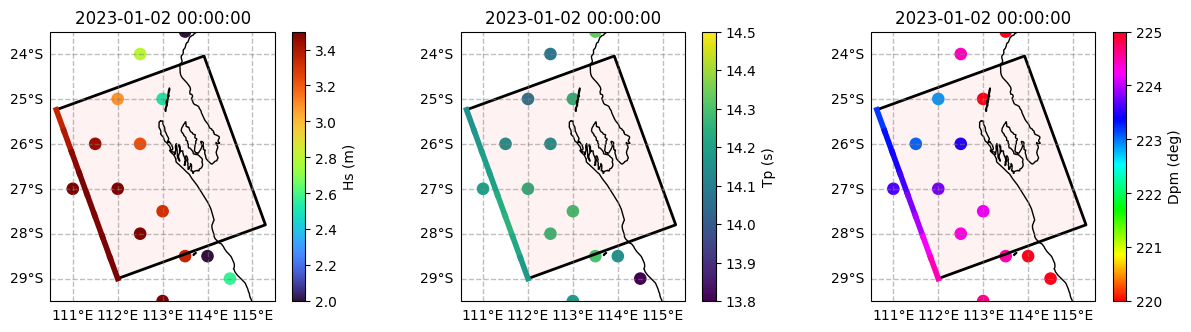

In [10]:
for time in df.index[::2]:
    plot_boundary_side(dset, tpars, grid, time)

### Boundary segment along multiple sides

Create `BOUNDSPEC SEGMENT` type SWAN boundary with the points defined along multiple,
contiguous sides of the computational grid.

The boundary is defined as `TPAR` files by selecting from the nearest points in the
source spectra dataset along the sides at the resolution defined by the `spacing`
parameter which by default corresponds to the grid spacing itself (use `"parent"` to
define the spacing based on spacing of points in the source spectra dataset, or set a
custom spacing if desired).

<div class="alert alert-block alert-warning">
⚠️ When using SIDES, the order at which each side is provided matters. Ensure the order
  and direction of each side are such that segments defined by each pair of points will
  all be contiguous.
</div>

In [11]:
workspace = Path(mkdtemp(dir="model"))

bnd = BoundspecSegmentXY(
    id="wa",
    source=source,
    sel_method="nearest",
    sel_method_kwargs={"tolerance": 2.0},
    location=SIDES(
        sides=[
            SIDE(side="south", direction="clockwise"),
            SIDE(side="west", direction="clockwise"),
            SIDE(side="north", direction="clockwise"),
        ],
    ),
)

cmd = bnd.get(destdir=workspace, grid=grid, time=times)
filename = cmd.split()[-2].split("=")[-1][1:-1]

print(f"{cmd}\n")
os.system(f"ls -l {workspace}");

BOUNDSPEC SEGMENT XY x=115.28892417 y=-27.80292950 x=114.81907786 y=-27.97393957 CONSTANT FILE fname='wa_tpar_000.bnd' seq=1
BOUNDSPEC SEGMENT XY x=114.81907786 y=-27.97393957 x=114.34923155 y=-28.14494964 CONSTANT FILE fname='wa_tpar_001.bnd' seq=1
BOUNDSPEC SEGMENT XY x=114.34923155 y=-28.14494964 x=113.87938524 y=-28.31595971 CONSTANT FILE fname='wa_tpar_002.bnd' seq=1
BOUNDSPEC SEGMENT XY x=113.87938524 y=-28.31595971 x=113.40953893 y=-28.48696979 CONSTANT FILE fname='wa_tpar_003.bnd' seq=1
BOUNDSPEC SEGMENT XY x=113.40953893 y=-28.48696979 x=112.93969262 y=-28.65797986 CONSTANT FILE fname='wa_tpar_004.bnd' seq=1
BOUNDSPEC SEGMENT XY x=112.93969262 y=-28.65797986 x=112.46984631 y=-28.82898993 CONSTANT FILE fname='wa_tpar_005.bnd' seq=1
BOUNDSPEC SEGMENT XY x=112.46984631 y=-28.82898993 x=112.00000000 y=-29.00000000 CONSTANT FILE fname='wa_tpar_006.bnd' seq=1
BOUNDSPEC SEGMENT XY x=112.00000000 y=-29.00000000 x=111.82898993 y=-28.53015369 CONSTANT FILE fname='wa_tpar_007.bnd' seq=1


In [12]:
# Load boundaries for each segment into dataframes

tpars = []
for row in cmd.split("\n"):
    parts = row.split()
    filename = parts[-2].split("=")[-1][1:-1]
    df = read_tpar(workspace / filename)
    df["x0"] = float(parts[3].split("=")[-1])
    df["x1"] = float(parts[5].split("=")[-1])
    df["y0"] = float(parts[4].split("=")[-1])
    df["y1"] = float(parts[6].split("=")[-1])
    tpars.append(df)

with pd.option_context("display.max_columns", 999):
    display(df)

,hs,tp,dpm,dspr,x0,x1,y0,y1
0,,,,,,,,
2023-01-01 00:00:00,1.31,14.08,241.64,20.66,113.450997,113.920844,-24.215169,-24.044159
2023-01-01 06:00:00,1.31,13.89,241.93,21.96,113.450997,113.920844,-24.215169,-24.044159
2023-01-01 12:00:00,1.37,13.93,242.71,22.38,113.450997,113.920844,-24.215169,-24.044159
2023-01-01 18:00:00,1.43,14.17,243.00,21.91,113.450997,113.920844,-24.215169,-24.044159
2023-01-02 00:00:00,1.56,14.33,243.23,21.32,113.450997,113.920844,-24.215169,-24.044159


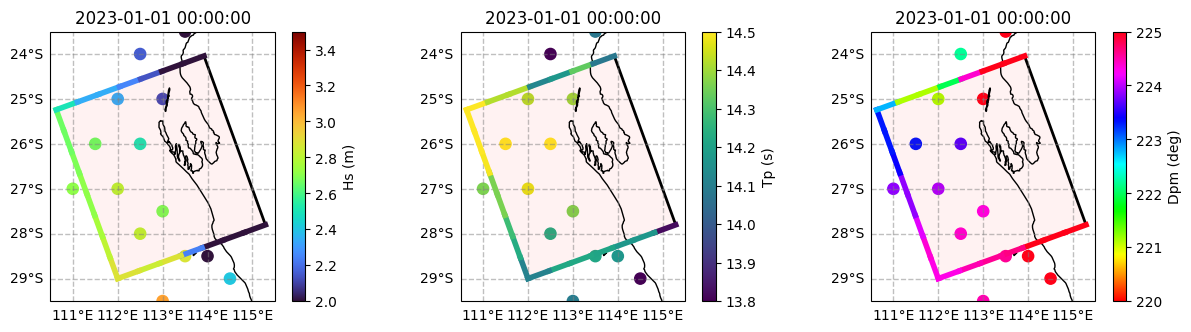

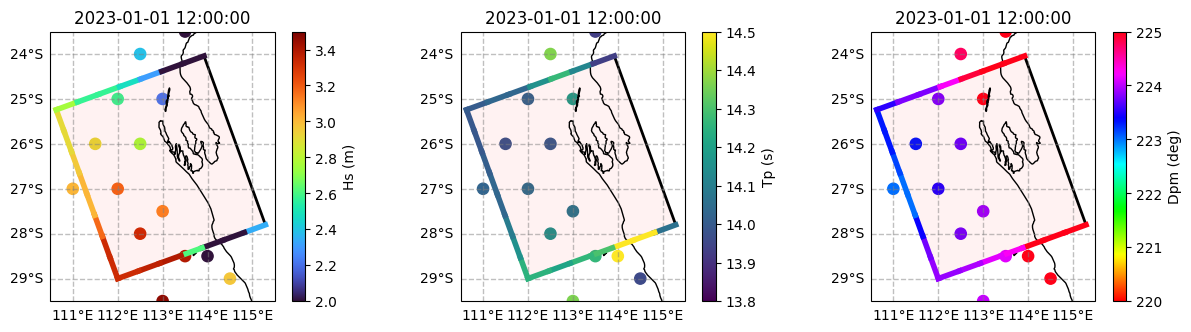

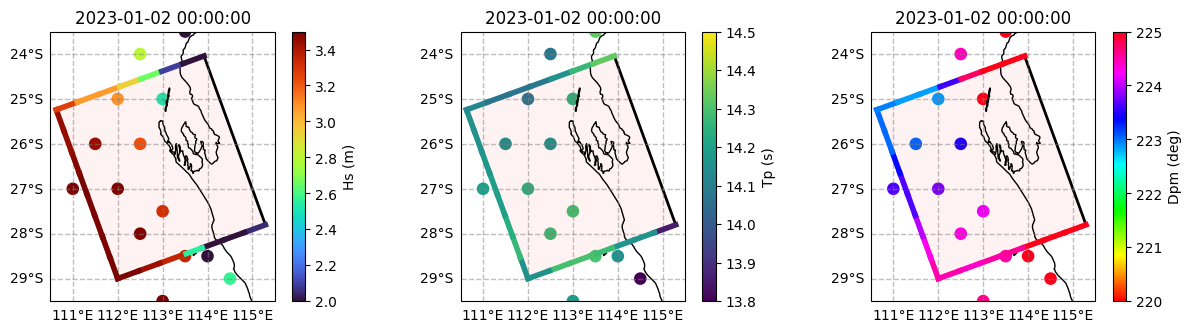

In [14]:
# Plot boundary stats

for time in df.index[::2]:
    plot_boundary_side(dset, tpars, grid, time)

### Boundary segment along multiple sides with custom spacing

Use a custom spacing of 1.0 degree to set the segment sizes. Notice the last segment is
adjsted to ensure the grid length is respected.

<div class="alert alert-block alert-info">
⚠️ In this example, sides are specified in the opposite order north-west-south with an
  appropriate direction `ccw` that ensures contiguous segments.
</div>

In [15]:
workspace = Path(mkdtemp(dir="model"))

bnd = BoundspecSegmentXY(
    id="wa",
    source=source,
    sel_method="nearest",
    sel_method_kwargs={"tolerance": 2.0},
    spacing=1.0,
    location=SIDES(
        sides=[
            SIDE(side="north", direction="ccw"),
            SIDE(side="west", direction="ccw"),
            SIDE(side="south", direction="ccw"),
        ],
    ),
)

cmd = bnd.get(destdir=workspace, grid=grid, time=times)
filename = cmd.split()[-2].split("=")[-1][1:-1]

print(f"{cmd}\n")
os.system(f"ls -l {workspace}");

BOUNDSPEC SEGMENT XY x=113.92084360 y=-24.04415902 x=112.98115098 y=-24.38617916 CONSTANT FILE fname='wa_tpar_000.bnd' seq=1
BOUNDSPEC SEGMENT XY x=112.98115098 y=-24.38617916 x=112.04145836 y=-24.72819930 CONSTANT FILE fname='wa_tpar_001.bnd' seq=1
BOUNDSPEC SEGMENT XY x=112.04145836 y=-24.72819930 x=111.10176574 y=-25.07021945 CONSTANT FILE fname='wa_tpar_002.bnd' seq=1
BOUNDSPEC SEGMENT XY x=111.10176574 y=-25.07021945 x=110.63191943 y=-25.24122952 CONSTANT FILE fname='wa_tpar_003.bnd' seq=1
BOUNDSPEC SEGMENT XY x=110.63191943 y=-25.24122952 x=110.97393957 y=-26.18092214 CONSTANT FILE fname='wa_tpar_004.bnd' seq=1
BOUNDSPEC SEGMENT XY x=110.97393957 y=-26.18092214 x=111.31595971 y=-27.12061476 CONSTANT FILE fname='wa_tpar_005.bnd' seq=1
BOUNDSPEC SEGMENT XY x=111.31595971 y=-27.12061476 x=111.65797986 y=-28.06030738 CONSTANT FILE fname='wa_tpar_006.bnd' seq=1
BOUNDSPEC SEGMENT XY x=111.65797986 y=-28.06030738 x=112.00000000 y=-29.00000000 CONSTANT FILE fname='wa_tpar_007.bnd' seq=1


,hs,tp,dpm,dspr,x0,x1,y0,y1
0,,,,,,,,
2023-01-01 00:00:00,1.94,13.82,225.0,14.52,114.819078,115.288924,-27.97394,-27.80293
2023-01-01 06:00:00,1.95,14.09,225.0,14.38,114.819078,115.288924,-27.97394,-27.80293
2023-01-01 12:00:00,2.34,14.06,225.0,18.83,114.819078,115.288924,-27.97394,-27.80293
2023-01-01 18:00:00,2.22,13.91,225.0,16.48,114.819078,115.288924,-27.97394,-27.80293
2023-01-02 00:00:00,2.05,13.85,225.0,13.39,114.819078,115.288924,-27.97394,-27.80293


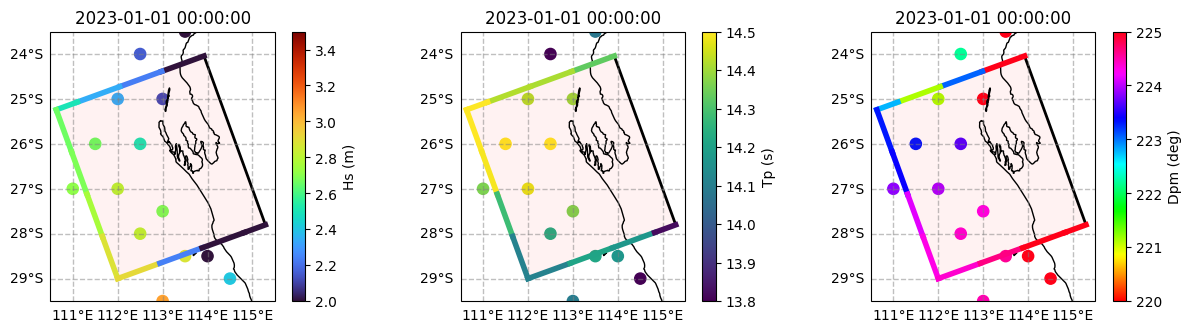

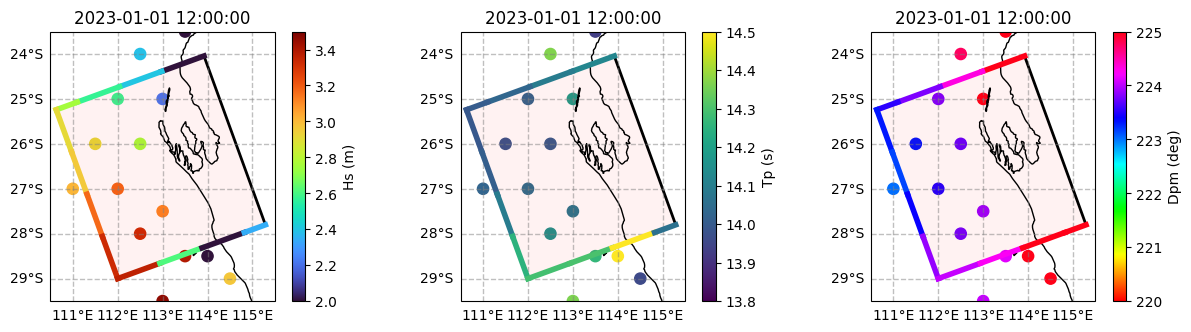

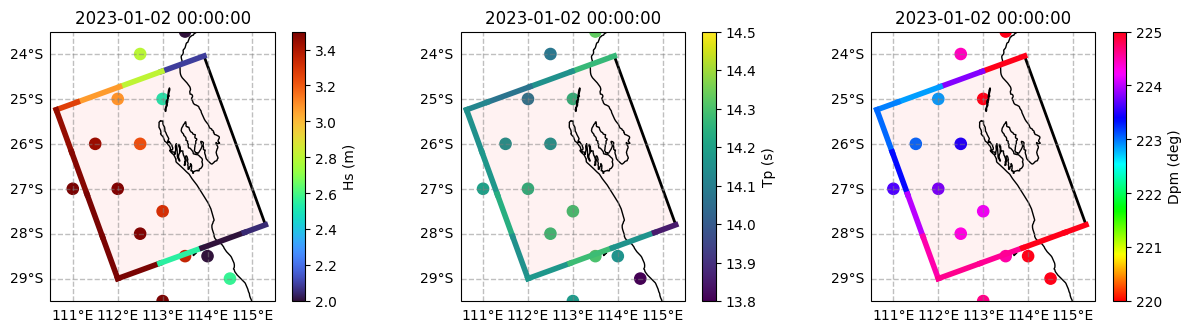

In [16]:
# Load boundaries for each segment and plot boundary stats

tpars = []
for row in cmd.split("\n"):
    parts = row.split()
    filename = parts[-2].split("=")[-1][1:-1]
    df = read_tpar(workspace / filename)
    df["x0"] = float(parts[3].split("=")[-1])
    df["x1"] = float(parts[5].split("=")[-1])
    df["y0"] = float(parts[4].split("=")[-1])
    df["y1"] = float(parts[6].split("=")[-1])
    tpars.append(df)

with pd.option_context("display.max_columns", 999):
    display(df)

for time in df.index[::2]:
    plot_boundary_side(dset, tpars, grid, time)

### Boundary segment along multiple sides with parent spacing

Set spacing from the minimum distance between spectral points in the source dataset.

In [17]:
workspace = Path(mkdtemp(dir="model"))

bnd = BoundspecSegmentXY(
    id="wa",
    source=source,
    sel_method="nearest",
    sel_method_kwargs={"tolerance": 2.0},
    spacing="parent",
    location=SIDES(
        sides=[
            SIDE(side="north", direction="ccw"),
            SIDE(side="west", direction="ccw"),
            SIDE(side="south", direction="ccw"),
        ],
    ),
)

cmd = bnd.get(destdir=workspace, grid=grid, time=times)
filename = cmd.split()[-2].split("=")[-1][1:-1]

print(f"{cmd}\n")
os.system(f"ls -l {workspace}");

BOUNDSPEC SEGMENT XY x=113.92084360 y=-24.04415902 x=113.25638058 y=-24.28600378 CONSTANT FILE fname='wa_tpar_000.bnd' seq=1
BOUNDSPEC SEGMENT XY x=113.25638058 y=-24.28600378 x=112.59191755 y=-24.52784854 CONSTANT FILE fname='wa_tpar_001.bnd' seq=1
BOUNDSPEC SEGMENT XY x=112.59191755 y=-24.52784854 x=111.92745453 y=-24.76969330 CONSTANT FILE fname='wa_tpar_002.bnd' seq=1
BOUNDSPEC SEGMENT XY x=111.92745453 y=-24.76969330 x=111.26299150 y=-25.01153807 CONSTANT FILE fname='wa_tpar_003.bnd' seq=1
BOUNDSPEC SEGMENT XY x=111.26299150 y=-25.01153807 x=110.63191943 y=-25.24122952 CONSTANT FILE fname='wa_tpar_004.bnd' seq=1
BOUNDSPEC SEGMENT XY x=110.63191943 y=-25.24122952 x=110.87376419 y=-25.90569254 CONSTANT FILE fname='wa_tpar_005.bnd' seq=1
BOUNDSPEC SEGMENT XY x=110.87376419 y=-25.90569254 x=111.11560895 y=-26.57015557 CONSTANT FILE fname='wa_tpar_006.bnd' seq=1
BOUNDSPEC SEGMENT XY x=111.11560895 y=-26.57015557 x=111.35745371 y=-27.23461859 CONSTANT FILE fname='wa_tpar_007.bnd' seq=1


,hs,tp,dpm,dspr,x0,x1,y0,y1
0,,,,,,,,
2023-01-01 00:00:00,1.94,13.82,225.0,14.52,114.657852,115.288924,-28.032621,-27.80293
2023-01-01 06:00:00,1.95,14.09,225.0,14.38,114.657852,115.288924,-28.032621,-27.80293
2023-01-01 12:00:00,2.34,14.06,225.0,18.83,114.657852,115.288924,-28.032621,-27.80293
2023-01-01 18:00:00,2.22,13.91,225.0,16.48,114.657852,115.288924,-28.032621,-27.80293
2023-01-02 00:00:00,2.05,13.85,225.0,13.39,114.657852,115.288924,-28.032621,-27.80293


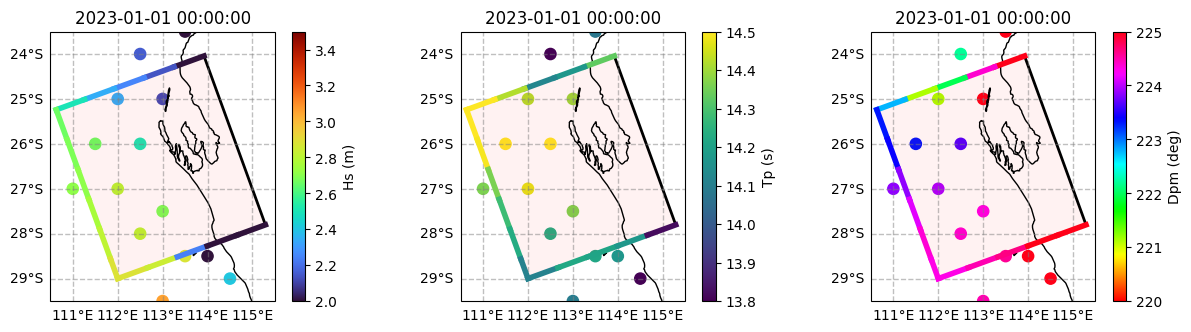

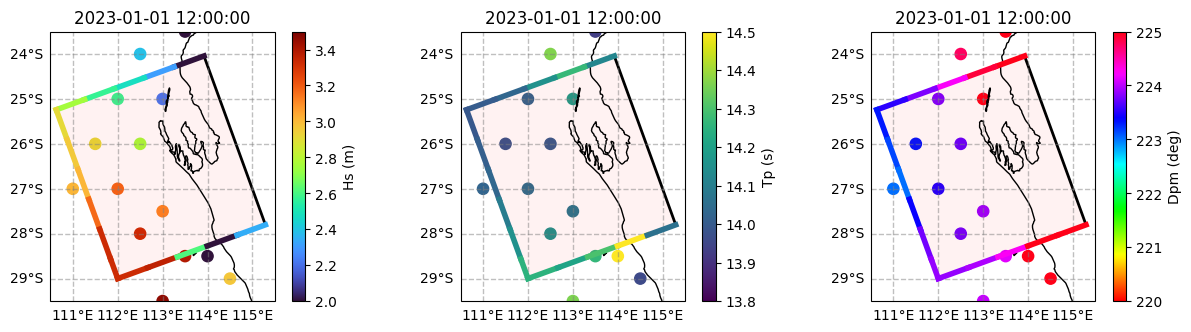

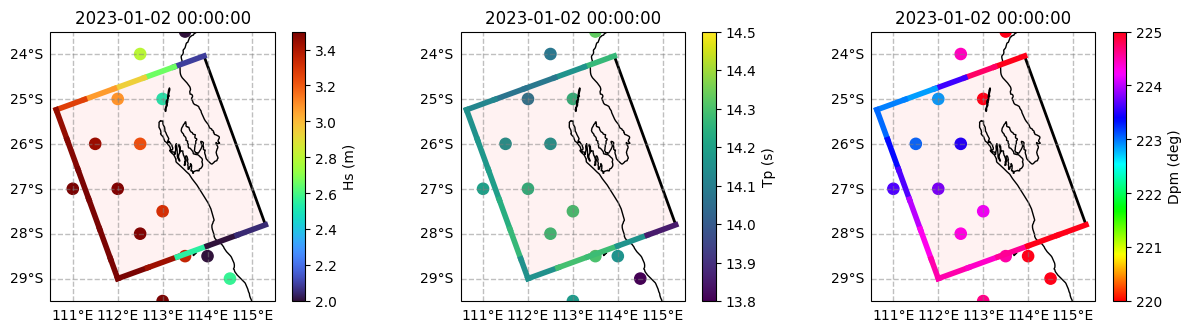

In [18]:
# Load boundaries for each segment and plot boundary stats

tpars = []
for row in cmd.split("\n"):
    parts = row.split()
    filename = parts[-2].split("=")[-1][1:-1]
    df = read_tpar(workspace / filename)
    df["x0"] = float(parts[3].split("=")[-1])
    df["x1"] = float(parts[5].split("=")[-1])
    df["y0"] = float(parts[4].split("=")[-1])
    df["y1"] = float(parts[6].split("=")[-1])
    tpars.append(df)

with pd.option_context("display.max_columns", 999):
    display(df)

for time in df.index[::2]:
    plot_boundary_side(dset, tpars, grid, time)

### User-specified boundary points

Users are free to set segments explicitly using the XY type

In [20]:
workspace = Path(mkdtemp(dir="model"))

# Define the grid vertices as boundary points
xb, yb = grid.boundary_points()
for point in zip(xb, yb):
    print(point)

bnd = BoundspecSegmentXY(
    id="wa",
    source=source,
    sel_method="idw",
    sel_method_kwargs={"tolerance": 2.0},
    location=XY(x=xb, y=yb)
)

cmd = bnd.get(destdir=workspace, grid=grid, time=times)
filename = cmd.split()[-2].split("=")[-1][1:-1]

print(f"{cmd}\n")
os.system(f"ls -l {workspace}");

(112.0, -29.0)
(112.46984631039295, -28.828989928337165)
(112.9396926207859, -28.65797985667433)
(113.40953893117886, -28.486969785011496)
(113.87938524157181, -28.31595971334866)
(114.34923155196478, -28.144949641685827)
(114.81907786235773, -27.973939570022992)
(115.28892417275068, -27.80292949836016)
(115.11791410108785, -27.333083187967205)
(114.94690402942501, -26.863236877574252)
(114.77589395776218, -26.393390567181296)
(114.60488388609934, -25.923544256788343)
(114.43387381443651, -25.453697946395387)
(114.26286374277367, -24.983851636002434)
(114.09185367111084, -24.51400532560948)
(113.920843599448, -24.044159015216525)
(113.45099728905505, -24.21516908687936)
(112.9811509786621, -24.386179158542195)
(112.51130466826915, -24.55718923020503)
(112.0414583578762, -24.728199301867864)
(111.57161204748323, -24.8992093735307)
(111.10176573709028, -25.070219445193533)
(110.63191942669732, -25.241229516856365)
(110.80292949836016, -25.71107582724932)
(110.97393957002299, -26.18092213

,hs,tp,dpm,dspr,x0,x1,y0,y1
0,,,,,,,,
2023-01-01 00:00:00,2.91,14.14,224.35,25.31,111.82899,112.0,-28.530154,-29.0
2023-01-01 06:00:00,2.99,14.11,224.08,26.31,111.82899,112.0,-28.530154,-29.0
2023-01-01 12:00:00,3.35,14.25,223.91,28.19,111.82899,112.0,-28.530154,-29.0
2023-01-01 18:00:00,3.62,14.31,224.13,29.76,111.82899,112.0,-28.530154,-29.0
2023-01-02 00:00:00,3.59,14.18,224.47,30.52,111.82899,112.0,-28.530154,-29.0


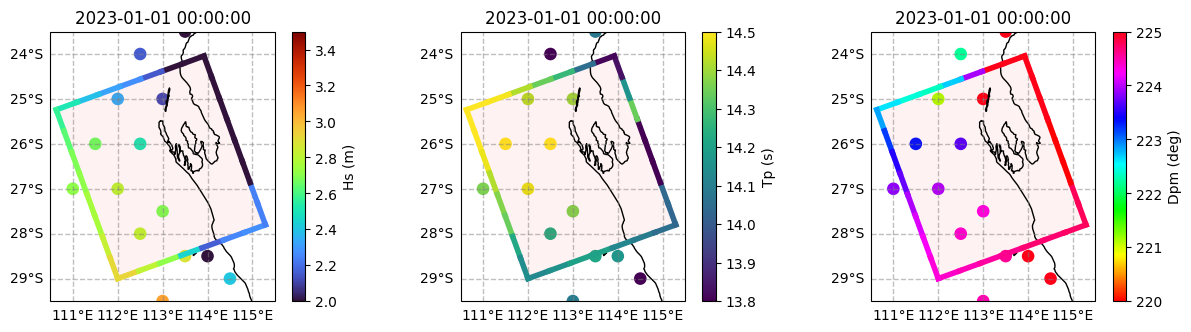

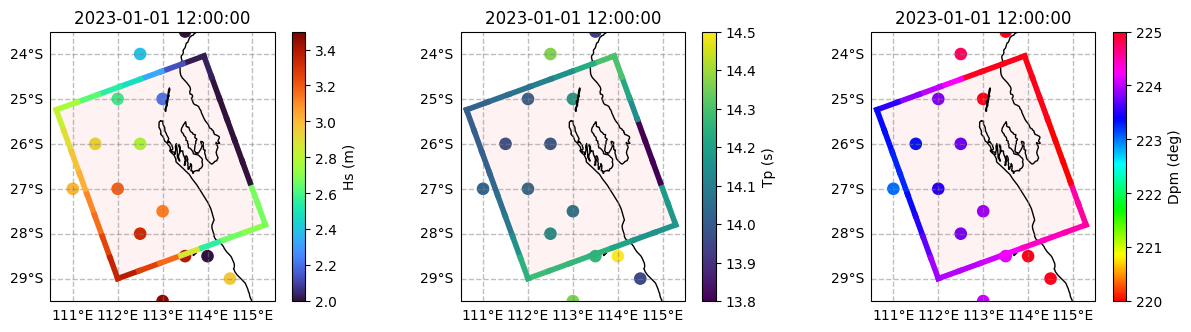

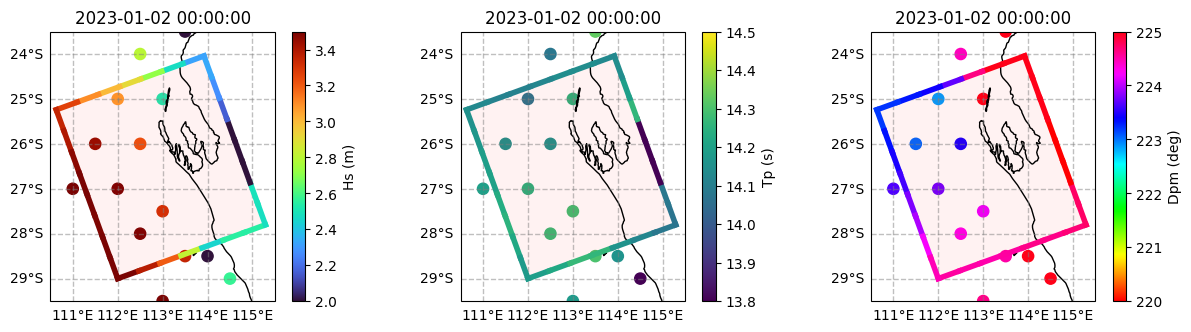

In [21]:
# Load boundaries for each segment and plot boundary stats

tpars = []
for row in cmd.split("\n"):
    parts = row.split()
    filename = parts[-2].split("=")[-1][1:-1]
    df = read_tpar(workspace / filename)
    df["x0"] = float(parts[3].split("=")[-1])
    df["x1"] = float(parts[5].split("=")[-1])
    df["y0"] = float(parts[4].split("=")[-1])
    df["y1"] = float(parts[6].split("=")[-1])
    tpars.append(df)

# Display the contents of one of the TPAR files
with pd.option_context("display.max_columns", 999):
    display(df)

# Plot source and boundary stats
for time in df.index[::2]:
    plot_boundary_side(dset, tpars, grid, time)